# FunNow Python Test

### by Yueh-Han Chen

### Dataset Overview

- registration_log.csv: 2018年一到六月註冊帳號的使用者及他們註冊的時間
- app_open_log.csv: 2018年一到九月使用者打開 app 的時間紀錄
- purchase_log.csv: 2018年一到七月使用者的訂單資訊


### Research Questions:
1. 使用所給的資料做出依使用者註冊月份的月留存率 (monthly retention) 圖
2. 將使用者根據以下條件分成兩群，計算兩群人數，並分別作出兩群人的月留存率 (monthly retention) 圖
     1. 註冊後一個月內有消費 
     2. 註冊後一個月內沒有消費
3. 註冊後一個月內有消費的使用者中，第一月到第四個月的人均月消費次數線條圖 
4. 從第一到第四個月總訂單中，分出以下四群消費者，列出個群人數、佔比
    1. 4個月內在每月都消費過
    2. 4個月內在其中3個月消費過
    3. 4個月內在其中2個月消費過
    4. 只在第一個月消費

### Other Possible Research Questions:
5. 分析一月的cohort: 在第八、第九月還留存的用戶他們從註冊至今總共貢獻的訂單數，佔整個cohort從一月到九月總訂單量的多少%？
6. What are the percentages that people book the service by within one hour, within 12 hours, and within a day?

## Data Wrangling

### Data Gathering

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import timedelta
import datetime
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
#load data
df_reg = pd.read_csv('registration_log.csv')
df_op = pd.read_csv('app_open_log.csv')
df_paid = pd.read_csv('purchase_log.csv')

### Data Assessing

In [3]:
# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6367 entries, 0 to 6366
Data columns (total 2 columns):
user_id        6367 non-null object
signup_time    6367 non-null object
dtypes: object(2)
memory usage: 99.6+ KB


In [5]:
# there is no duplicates.
df_reg.user_id.nunique()

6367

In [6]:
df_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603115 entries, 0 to 603114
Data columns (total 2 columns):
user_id          603115 non-null object
app_open_time    603115 non-null object
dtypes: object(2)
memory usage: 9.2+ MB


In [7]:
df_paid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 2 columns):
user_id          2058 non-null object
purchase_time    2058 non-null object
dtypes: object(2)
memory usage: 32.3+ KB


### Assessment Report:
- The time columns in these three tables are object data type, but I want datetime data type.

### Data Cleaning

In [8]:
# convert the signup_time, app_open_time, and purchase_time to datetime data type

df_reg.signup_time = pd.to_datetime(df_reg.signup_time)
df_op.app_open_time = pd.to_datetime(df_op.app_open_time)
df_paid.purchase_time = pd.to_datetime(df_paid.purchase_time)

Test

In [9]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6367 entries, 0 to 6366
Data columns (total 2 columns):
user_id        6367 non-null object
signup_time    6367 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 99.6+ KB


## Question 1: 使用所給的資料做出依使用者註冊月份的月留存率 (monthly retention) 圖

### 1st Edition: The lenient way 
(No matter users registered on 1/1 or 1/31, when users opened again on 2/1, it counted in the 2nd month retention. )

In [10]:
# create a new column called month to save the month of each row
df_reg['Join_period'] = 0

for i in range(0, df_reg.shape[0]):
    df_reg.Join_period[i] = df_reg.signup_time[i].month

In [11]:
# calculate the total cohorts by join_period and chagne the column name to new_users
retention_df = df_reg.groupby('Join_period').user_id.count().to_frame()
retention_df.rename(columns={'user_id':'New_users'}, inplace=True)

In [12]:
# create columns for each month
for i in range(1,10):  
    retention_df[i]= None

In [13]:
retention_df

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,724,None,None,None,None,None,None,None,None,None
2,888,None,None,None,None,None,None,None,None,None
3,1359,None,None,None,None,None,None,None,None,None
4,1270,None,None,None,None,None,None,None,None,None
5,1135,None,None,None,None,None,None,None,None,None
6,991,None,None,None,None,None,None,None,None,None


In [14]:
# create each cohort from Jan. to Jun.

cohort_1 = df_reg.query('signup_time < "2018/2"')
cohort_2 = df_reg.query('signup_time < "2018/3" and signup_time > "2018/2"')
cohort_3 = df_reg.query('signup_time < "2018/4" and signup_time > "2018/3"')
cohort_4 = df_reg.query('signup_time < "2018/5" and signup_time > "2018/4"')
cohort_5 = df_reg.query('signup_time < "2018/6" and signup_time > "2018/5"')
cohort_6 = df_reg.query('signup_time < "2018/7" and signup_time > "2018/6"')

In [15]:
# create each open record from Jan. to Sep.

open_1 = df_op.query('app_open_time < "2018/2"')
open_2 = df_op.query('app_open_time < "2018/4" and app_open_time > "2018/2"')
open_3 = df_op.query('app_open_time < "2018/5" and app_open_time > "2018/3"')
open_4 = df_op.query('app_open_time < "2018/6" and app_open_time > "2018/4"')
open_5 = df_op.query('app_open_time < "2018/7" and app_open_time > "2018/5"')
open_6 = df_op.query('app_open_time < "2018/8" and app_open_time > "2018/6"')
open_7 = df_op.query('app_open_time < "2018/9" and app_open_time > "2018/7"')
open_8 = df_op.query('app_open_time < "2018/10" and app_open_time > "2018/8"')
open_9 = df_op.query('app_open_time < "2018/11" and app_open_time > "2018/9"')

In [16]:
cohort_list = [cohort_1, cohort_2, cohort_3, cohort_4, cohort_5, cohort_6]
open_list = [open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9]

In [17]:
# 先跑第一個period，一個月一個月計算，再跑下個period

def lenient_retention(df, cohort_list, open_list, max_join_month, max_open_month, decimal):
    offset = 0 # for later column to offset 1
    for join_period in range(1, max_join_month+1):

        if join_period != 1:
            offset = 1-join_period

        for m in range(join_period, max_open_month+1):
            #計算cohort與open的重複id，來算出retention
            count = pd.Series(list(set(cohort_list[join_period-1].user_id).intersection(set(open_list[m-1].user_id)))).nunique()
            df[m + offset][join_period] = str(round(count/cohort_list[join_period-1].shape[0], 2) * 100)[0:decimal].replace('.','')+'%'

In [18]:
lenient_retention(retention_df, cohort_list, open_list, 6, 9, 2)

In [19]:
retention_df

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,724,98%,47%,34%,31%,28%,24%,21%,20%,14%
2,888,99%,43%,33%,28%,25%,25%,21%,14%,None
3,1359,98%,48%,35%,28%,25%,20%,14%,None,None
4,1270,99%,45%,34%,31%,26%,16%,None,None,None
5,1135,99%,47%,37%,28%,19%,None,None,None,None
6,991,99%,50%,37%,22%,None,None,None,None,None


### 2nd Edition: The strict way
(The users of each cohort will only be counted in the 2nd month retention when opening the App again 30 days after registration.)

In [20]:
# calculate the total cohorts by join_period and chagne the column name to new_users
retention2_df = df_reg.groupby('Join_period').user_id.count().to_frame()
retention2_df.rename(columns={'user_id':'New_users'}, inplace=True)

In [21]:
# create columns for each month
for i in range(1,10):  
    retention2_df[i]= None

In [22]:
retention2_df

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,724,None,None,None,None,None,None,None,None,None
2,888,None,None,None,None,None,None,None,None,None
3,1359,None,None,None,None,None,None,None,None,None
4,1270,None,None,None,None,None,None,None,None,None
5,1135,None,None,None,None,None,None,None,None,None
6,991,None,None,None,None,None,None,None,None,None


In [23]:
# create each cohort from Jan. to Jun.

cohort_1 = df_reg.query('signup_time < "2018/2"')
cohort_2 = df_reg.query('signup_time < "2018/3" and signup_time > "2018/2"')
cohort_3 = df_reg.query('signup_time < "2018/4" and signup_time > "2018/3"')
cohort_4 = df_reg.query('signup_time < "2018/5" and signup_time > "2018/4"')
cohort_5 = df_reg.query('signup_time < "2018/6" and signup_time > "2018/5"')
cohort_6 = df_reg.query('signup_time < "2018/7" and signup_time > "2018/6"')

In [24]:
cohort_list = [cohort_1, cohort_2, cohort_3, cohort_4, cohort_5, cohort_6]

In [25]:
# 先跑第一個period => 第一個月 => 一天一天比較並算出總月retention => 重複步驟第二個月 => 整個period跑完，跑下個period

def strict_retention(df, cohort_list, df_open, max_join_month, max_open_month, decimal):
    for join_period in range(0, max_join_month): 
        month=0
        for p in range(0, 30*max_open_month, 30): #30天-30天跑
            count=0
            month += 1
            for signup_date in cohort_list[join_period].signup_time.dt.strftime('%Y-%m-%d').unique(): 
            #run 每月的 unique signup date，一個一個去比較
                before_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=1))
                current_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=p))
                next_30_days = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=p+30))
                count += pd.Series(list(set(cohort_list[join_period][(cohort_list[join_period].signup_time < before_date) & (cohort_list[join_period].signup_time > signup_date)].user_id).intersection(set(df_open[(df_open.app_open_time < next_30_days) & (df_open.app_open_time > current_date)].user_id)))).nunique()
            df[month][join_period+1] = str(round(count/cohort_list[join_period].shape[0], 2) * 100)[0:decimal].replace('.','')+'%'

In [26]:
strict_retention(retention2_df, cohort_list, df_op, 6, 9, 2)

In [27]:
for i in range(1,7):
    for j in range(1,10):
        if retention2_df[j][i] == '0%':
            retention2_df[j][i] = None

In [28]:
retention2_df

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,724,98%,33%,24%,22%,21%,15%,16%,14%,11%
2,888,99%,28%,22%,20%,18%,18%,16%,10%,None
3,1359,98%,33%,24%,19%,18%,14%,9%,None,None
4,1270,99%,30%,25%,24%,18%,11%,None,None,None
5,1135,98%,31%,28%,21%,14%,None,None,None,None
6,991,99%,36%,26%,16%,None,None,None,None,None


# Question 2: 將使用者根據以下條件分成兩群，計算兩群人數，並分別作出兩群人的月留存率 (monthly retention) 圖
1. 註冊後一個月內有消費
2. 註冊後一個月內沒有消費

### 1. 註冊後一個月內有消費


In [186]:
paid_users_counts_by_month = [] # first month of each period
paid_cohort_list = [] # cohort list of each period

#run period first
for join_period in range(0, 6): 

    count=0
    monthly_cohort =[]

    #find unique signup date in each month
    for signup_date in cohort_list[join_period].signup_time.dt.strftime('%Y-%m-%d').unique():
        before_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=1))
        current_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=0))
        next_30_days = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=30))
        
        # this is a daily cohort
        a_cohort = list(set(cohort_list[join_period][(cohort_list[join_period].signup_time < before_date) & (cohort_list[join_period].signup_time > signup_date)].user_id).intersection(set(df_paid[(df_paid.purchase_time < next_30_days) & (df_paid.purchase_time > current_date)].user_id)))
        # add it to the monthly_cohort
        monthly_cohort.extend(a_cohort)

        cohort = pd.Series(a_cohort)
        # accumulate the sum until this period ends
        count += cohort.nunique()

    #create a dataframe for each period 
    monthly_df = pd.Series(monthly_cohort).to_frame()  
    monthly_df.rename(columns={0:'user_id'}, inplace=True)
    paid_cohort_list.append(monthly_df)
    paid_users_counts_by_month.append(count) # document the monthly sum

In [187]:
# merge the paid_cohort list with the signup dataframe, so that we will have the "signup_time" that we can use it to 
#calculate retention later on.

for i in range(0, 6): 
    paid_cohort_list[i] = paid_cohort_list[i].merge(cohort_list[i], left_on='user_id', right_on='user_id', how='inner')

In [188]:
#test: this should print out a dataframe with signup time
paid_cohort_list[0].head()

,user_id,signup_time,Join_period
0,3b2825eb1b54022b2b1b9172c00bcfda,2018-01-01 05:22:00,1
1,110a49fae39f8bf4ee9ee2d40ebc5600,2018-01-02 10:05:00,1
2,68bcfcc7d0dccedf49c727c6549d5606,2018-01-02 15:15:00,1
3,5ee7a9a5edeb31633746f9a57440f243,2018-01-02 17:31:00,1
4,c4047fd8cf53b4135d9371e70b12eeea,2018-01-02 06:20:00,1


In [189]:
# create a dataframe for our retention
paid_within_30_df = pd.Series(paid_users_counts_by_month).to_frame()
paid_within_30_df

,0
0,102
1,113
2,140
3,156
4,163
5,130


In [190]:
# rename it to new_users, and create a new column called 'Join_period'. I will replace this with the index next cell.
paid_within_30_df.rename(columns={0:'New_users'}, inplace=True)
paid_within_30_df['Join_period'] = [1,2,3,4,5,6]

In [191]:
paid_within_30_df.set_index('Join_period', inplace=True)

# create columns for each month
for i in range(1,10):  
    paid_within_30_df[i]= None
    
paid_within_30_df 

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,102,None,None,None,None,None,None,None,None,None
2,113,None,None,None,None,None,None,None,None,None
3,140,None,None,None,None,None,None,None,None,None
4,156,None,None,None,None,None,None,None,None,None
5,163,None,None,None,None,None,None,None,None,None
6,130,None,None,None,None,None,None,None,None,None


In [192]:
# use the strict_retention function I just built for question 1
strict_retention(paid_within_30_df, paid_cohort_list, df_op, 6, 9, 3)

In [195]:
for i in range(1,7):
    for j in range(1,10):
        if paid_within_30_df[j][i] == '00%' or paid_within_30_df[j][i] =='10%':
            paid_within_30_df[j][i] = None

In [196]:
paid_within_30_df 

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,102,100%,70%,54%,45%,41%,38%,36%,35%,31%
2,113,100%,59%,50%,48%,44%,45%,41%,28%,None
3,140,100%,74%,59%,56%,61%,40%,33%,None,None
4,156,100%,63%,65%,65%,45%,33%,None,None,None
5,163,100%,63%,64%,54%,39%,None,None,None,None
6,130,100%,69%,53%,41%,None,None,None,None,None


### 2. 註冊後一個月內沒有消費

In [92]:
unpaid_cohort_list = paid_cohort_list

# use our existed cohorts of users paid within the first month to find the difference with original cohorts, 
#meaning the users that didn't purchase within the first month
for i in range(0,6):
    unpaid_cohort_list[i] = pd.concat([paid_cohort_list[i], cohort_list[i]]).drop_duplicates(keep=False)

In [93]:
#test: the size of the cohort in Jan should be 724-102 = 622
unpaid_cohort_list[0].shape[0]

622

In [94]:
#create a dataframe for retention
unpaid_within_30_df = retention2_df['New_users'] - paid_within_30_df['New_users']

unpaid_within_30_df = pd.Series(unpaid_within_30_df).to_frame()

In [95]:
unpaid_within_30_df

,New_users
Join_period,
1,622
2,775
3,1219
4,1114
5,972
6,861


In [96]:
# create columns for each month
for i in range(1,10):  
    unpaid_within_30_df[i]= None
    
unpaid_within_30_df 

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,622,None,None,None,None,None,None,None,None,None
2,775,None,None,None,None,None,None,None,None,None
3,1219,None,None,None,None,None,None,None,None,None
4,1114,None,None,None,None,None,None,None,None,None
5,972,None,None,None,None,None,None,None,None,None
6,861,None,None,None,None,None,None,None,None,None


In [97]:
# use the strict_retention function I just built
strict_retention(unpaid_within_30_df, unpaid_cohort_list, df_op, 6, 9, 2)

In [98]:
for i in range(1,7):
    for j in range(1,10):
        if unpaid_within_30_df[j][i] == '0%':
            unpaid_within_30_df[j][i] = None

In [99]:
unpaid_within_30_df

,New_users,1,2,3,4,5,6,7,8,9
Join_period,,,,,,,,,,
1,622,98%,27%,19%,19%,18%,12%,13%,10%,7%
2,775,99%,24%,18%,15%,14%,14%,13%,7%,None
3,1219,97%,28%,20%,15%,13%,11%,7%,None,None
4,1114,99%,25%,20%,18%,14%,8%,None,None,None
5,972,98%,25%,22%,16%,10%,None,None,None,None
6,861,98%,31%,22%,12%,None,None,None,None,None


# ----------- Extra -----------

# Question 3: 註冊後一個月內有消費的使用者中，第一月到第四個月的人均月消費次數線條圖
(I only use cohorts 1 to cohort 4, since our paid_df only recorded till July.)

In [100]:
# get our paid cohort back by offsetting it.

for i in range(0,4):
    paid_cohort_list[i] = pd.concat([paid_cohort_list[i], cohort_list[i]]).drop_duplicates(keep=False)
paid_cohort_list[0].shape[0]

102

In [101]:
# list of the users counts in the first 4 months
first4month_count_list = []

# 先找第一個月 => 從paid cohort裡的第一個period找 => 一個一個id找 => 如果此id出現在此月(30天)的paid dataframe出現過，就算購買過 
# => 在算下個period的第一個月 => 跑完每個period之後 => 再跑第二個月 => 
# 再從一個一個period裡的一個個id去跑，是否id在paid dataframe的第二個月有出現過
for m in range(0,120,30):
    month_count_list=[]
    for join_period in range(0,4):
        for i in range(0, paid_cohort_list[join_period].shape[0]):
            count = 0
            date = str(list(paid_cohort_list[join_period][i: i+1].signup_time.dt.strftime('%Y-%m-%d'))[0])
            current_date = str(datetime.datetime.strptime(date, '%Y-%m-%d').date() + timedelta(days=m+0))
            next_30_days = str(datetime.datetime.strptime(date, '%Y-%m-%d').date() + timedelta(days=m+30))

            current_id = list(paid_cohort_list[join_period][i: i+1].user_id)[0]
            for id in list(df_paid[(df_paid.purchase_time < next_30_days) & (df_paid.purchase_time > current_date)].user_id):
                if current_id == id:
                    count+=1    
            month_count_list.append(count)
    first4month_count_list.append(month_count_list)

In [102]:
#將每個list轉成dataframe以便下面整合
first_month_df = pd.Series(first4month_count_list[0]).to_frame().rename(columns={0:'count'})
second_month_df = pd.Series(first4month_count_list[1]).to_frame().rename(columns={0:'count'})
third_month_df = pd.Series(first4month_count_list[2]).to_frame().rename(columns={0:'count'})
fourth_month_df = pd.Series(first4month_count_list[3]).to_frame().rename(columns={0:'count'})

In [103]:
#將全部df整合在一起
combined_df = first_month_df.rename(columns={'count':'first_month'})
combined_df['second_month'] = second_month_df['count']
combined_df['third_month'] = third_month_df['count']
combined_df['fourth_month'] = fourth_month_df['count']

In [104]:
combined_df

,first_month,second_month,third_month,fourth_month
0,1,0,0,0
1,1,2,1,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,1
6,1,0,0,1
7,1,0,0,0
8,1,0,0,0
9,2,0,0,1


In [107]:
total_count = combined_df.shape[0]

In [108]:
# make a frequently use plot description function for later vizualization

def desc(size=None, title=None, xscale=None, yscale=None, xlabel=None, ylabel=None, xlim=None, ylim=None, xticks1=None, xticks2=None, yticks1=None, yticks2=None,legend_title=None, legend_labels=None):
    # this function must be placed above the code of the plots
    if size:
        plt.figure(figsize=size)
    if title:
        plt.title(title);
    if xscale:
        plt.xscale(xscale);
    if yscale:
        plt.yscale(yscale);
    if xlabel:
        plt.xlabel(xlabel);
    if ylabel:
        plt.ylabel(ylabel);
    if xlim:
        plt.xlim(xlim);
    if ylim:
        plt.ylim(ylim);
    if xticks1:
        plt.xticks(xticks1, xticks2);
    if yticks1:
        plt.yticks(yticks1, yticks2);
    if legend_title:
        plt.legend(title=legend_title);
        if legend_labels:
            plt.legend(title=legend_title, labels=legend_labels);

In [109]:
# calculate the avg. purchase rate by month
purchase_rate = [combined_df.first_month.sum()/total_count, combined_df.second_month.sum()/total_count, combined_df.third_month.sum()/total_count, combined_df.fourth_month.sum()/total_count]
purchase_rate_df = pd.Series(purchase_rate).to_frame().rename(columns={0:'rate'})
purchase_rate_df['month'] = '1','2','3', '4'

In [110]:
purchase_rate_df

,rate,month
0,1.379648,1
1,0.320939,2
2,0.299413,3
3,0.244618,4


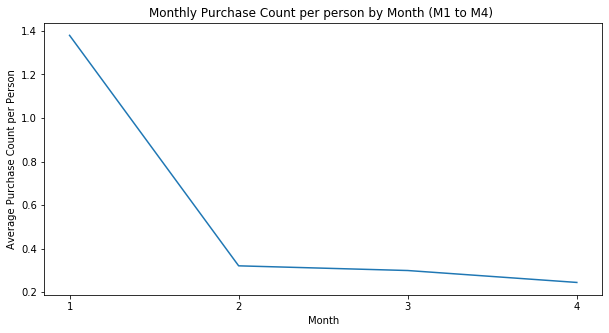

In [111]:
# visualize it
desc(title = 'Monthly Purchase Count per person by Month (M1 to M4) ', size=(10,5), xlabel='Month', ylabel = 'Average Purchase Count per Person')
plt.plot(purchase_rate_df.month, purchase_rate_df.rate);

- Note: The average purchase count dropped around 80% from M1 to M2, then dropped 35% from M2 to M3, and dropped 25% from M3 to M4

# Question 4: 從第一到第四個月總訂單中，分出以下四群消費者，列出佔比

1. 4個月內在每月都消費過
2. 4個月內在其中3個月消費過
3. 4個月內在其中2個月消費過
4. 只在第一個月消費

In [112]:
# 將會收集2D的list，第一個D是join_peiod從第一個加入月到第四個加入月，第二個D是第一到第四個月個月裡有購買的user id
paid_users_groups = []

for join_period in range(0, 4): 

    count=0
    one_period =[] #此list會紀錄第一到第四個月裡有購買的user id
    for m in range(0,4):
    #ㄧ個月一個月跑計算
        
        monthly_paid_cohort = [] #此list會紀錄此月裡有購買的user id
        
        for signup_date in cohort_list[join_period].signup_time.dt.strftime('%Y-%m-%d').unique():
        # 一天一天的singup date去跑計算在paid dataframe裡有重複的id
            day_cohort =[]
            before_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=1))
            current_date = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=0+30*m))
            next_30_days = str(datetime.datetime.strptime(signup_date, '%Y-%m-%d').date() + timedelta(days=30+30*m))
            day_cohort = list(set(cohort_list[join_period][(cohort_list[join_period].signup_time < before_date) & (cohort_list[join_period].signup_time > signup_date)].user_id).intersection(set(df_paid[(df_paid.purchase_time < next_30_days) & (df_paid.purchase_time > current_date)].user_id)))
            monthly_paid_cohort.extend(day_cohort)

        monthly_paid_cohort_df = pd.Series(monthly_paid_cohort).to_frame()  
        monthly_paid_cohort_df.rename(columns={0:'user_id'}, inplace=True)
        one_period.append(monthly_paid_cohort_df)
    paid_users_groups.append(one_period)

In [113]:
# test: the result should be 102, 113
paid_users_groups[0][0].shape[0], paid_users_groups[1][0].shape[0]

(102, 113)

In [118]:
paid_within_4m_df = pd.Series(paid_users_counts_by_month).to_frame()
paid_within_4m_df

,0
0,102
1,113
2,140
3,156
4,163
5,130


In [121]:
# create a dataframe

paid_within_4m_df.rename(columns={0:'New_users'}, inplace=True)
paid_within_4m_df['Join_period'] = [1,2,3,4,5,6]

paid_within_4m_df.set_index('Join_period', inplace=True)

# create columns for each month
for i in range(1,5):  
    paid_within_4m_df[i]= None
    
paid_within_4m_df 

,New_users,1,2,3,4
Join_period,,,,,
1,102,None,None,None,None
2,113,None,None,None,None
3,140,None,None,None,None
4,156,None,None,None,None
5,163,None,None,None,None
6,130,None,None,None,None


In [201]:
# create a dataframe
for i in range(1,5):
    for j in range(1,5):
        paid_within_4m_df[j][i] = str(round(paid_users_groups[i-1][j-1].shape[0]/paid_within_4m_df.New_users[i], 2)*100)[0:3].replace('.', '')+'%'
#paid_within_4m_df[0:4]

,New_users,1,2,3,4
Join_period,,,,,
1,102,100%,27%,25%,23%
2,113,100%,27%,21%,22%
3,140,100%,28%,21%,24%
4,156,100%,25%,24%,13%


In [179]:
four_p = []  #4個月內在每月都消費過
three_p = [] #4個月內在其中3個月消費過
two_p = []   #4個月內在其中2個月消費過
one_p = []   #只在第一個月消費


for i in range(0,4):
    one = set(paid_users_groups[i][0].user_id)
    two = set(paid_users_groups[i][1].user_id)
    three = set(paid_users_groups[i][2].user_id)
    four = set(paid_users_groups[i][3].user_id)
    
    #任兩個月的交集
    temp1_2 = list(one.intersection(two))    
    temp1_3 = list(one.intersection(three))
    temp1_4 = list(one.intersection(four))
    temp2_3 = list(two.intersection(three))
    temp3_4 = list(three.intersection(four))
    
    #4個月內在每月都消費過，代表所有月份的交集: 1234
    four_p.extend(list(set(temp1_2).intersection(set(temp3_4))))
    
    #4個月內在其中3個月消費過，代表只能出現在其中三個月: 123, 124, or 134
    three_p.extend(list(set(list(set(temp1_2).intersection(set(temp1_3)))).difference(set(temp1_4))))
    three_p.extend(list(set(list(set(temp1_2).intersection(set(temp1_4)))).difference(set(temp1_3))))
    three_p.extend(list(set(list(set(temp1_3).intersection(set(temp1_4)))).difference(set(temp1_2))))
    
    #4個月內在其中2個月消費過: 12, 13, 14
    two_p.extend(list(set(list(set(temp1_2).difference(set(temp1_3)))).difference(set(temp1_4))))
    two_p.extend(list(set(list(set(temp1_3).difference(set(temp1_2)))).difference(set(temp1_4))))
    two_p.extend(list(set(list(set(temp1_4).difference(set(temp1_2)))).difference(set(temp1_3))))
    
    #only the first month
    one_p.extend(list(set(set(list(one.difference(two))).difference(three)).difference(four)))

In [180]:
# total amount
paid_within_4m_df.New_users[0:4].sum()

511

In [185]:
len(np.unique(np.array(four_p))), len(np.unique(np.array(four_p)))/paid_within_4m_df.New_users[0:4].sum()

(30, 0.05870841487279843)

In [184]:
len(np.unique(np.array(three_p))), len(np.unique(np.array(three_p)))/paid_within_4m_df.New_users[0:4].sum()

(41, 0.08023483365949119)

In [182]:
len(np.unique(np.array(two_p))), len(np.unique(np.array(two_p)))/paid_within_4m_df.New_users[0:4].sum()

(78, 0.15264187866927592)

In [175]:
len(np.unique(np.array(one_p))), len(np.unique(np.array(one_p)))/paid_within_4m_df.New_users[0:4].sum()

(362, 0.7084148727984344)

Note: 
1. 4個月內在每月都消費過:    6% (30)
2. 4個月內在其中3個月消費過: 8% (41)
3. 4個月內在其中2個月消費過: 15% (78)
4. 只在第一個月消費:        71% (362)